In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

start = '2020-01-01'
end = '2025-03-31'

# ✅ DOWNLOAD EACH TICKER SEPARATELY — DO NOT COMBINE
tsla = yf.Ticker("TSLA").history(start=start, end=end)
sp500 = yf.Ticker("^GSPC").history(start=start, end=end)
t_bill = yf.Ticker("^IRX").history(start=start, end=end)

# ✅ Check for flat columns
print("TSLA Columns:", tsla.columns)





TSLA Columns: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [2]:
print("TSLA:", tsla.shape, "from", tsla.index.min(), "to", tsla.index.max())
print("SP500:", sp500.shape, "from", sp500.index.min(), "to", sp500.index.max())
print("T-Bill:", t_bill.shape, "from", t_bill.index.min(), "to", t_bill.index.max())






TSLA: (1317, 7) from 2020-01-02 00:00:00-05:00 to 2025-03-28 00:00:00-04:00
SP500: (1317, 7) from 2020-01-02 00:00:00-05:00 to 2025-03-28 00:00:00-04:00
T-Bill: (1317, 7) from 2020-01-02 00:00:00-06:00 to 2025-03-28 00:00:00-05:00


In [3]:
# Remove timezone info to make index comparable
tsla.index = tsla.index.tz_localize(None)
sp500.index = sp500.index.tz_localize(None)
t_bill.index = t_bill.index.tz_localize(None)

# Recompute common index
common_idx = tsla.index.intersection(sp500.index).intersection(t_bill.index)

# Filter to common dates
tsla = tsla.loc[common_idx]
sp500 = sp500.loc[common_idx]
t_bill = t_bill.loc[common_idx]


In [4]:
# Calculate returns
tsla['Returns'] = np.log(tsla['Close'] / tsla['Close'].shift(1))
sp500['Returns'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
t_bill['Daily_RF'] = (t_bill['Close'] / 100) / 252

# Merge final dataset
data = pd.DataFrame({
    'TSLA_Return': tsla['Returns'],
    'SP500_Return': sp500['Returns'],
    'RiskFree': t_bill['Daily_RF']
}).dropna()

# Preview
print(data.tail())
print(data.shape)


            TSLA_Return  SP500_Return  RiskFree
Date                                           
2025-03-24     0.112735      0.017492  0.000166
2025-03-25     0.034423      0.001573  0.000166
2025-03-26    -0.057424     -0.011220  0.000166
2025-03-27     0.003925     -0.003312  0.000166
2025-03-28    -0.035705     -0.019935  0.000166
(1316, 3)


**Phase 2**: Exploratory Data Analysis

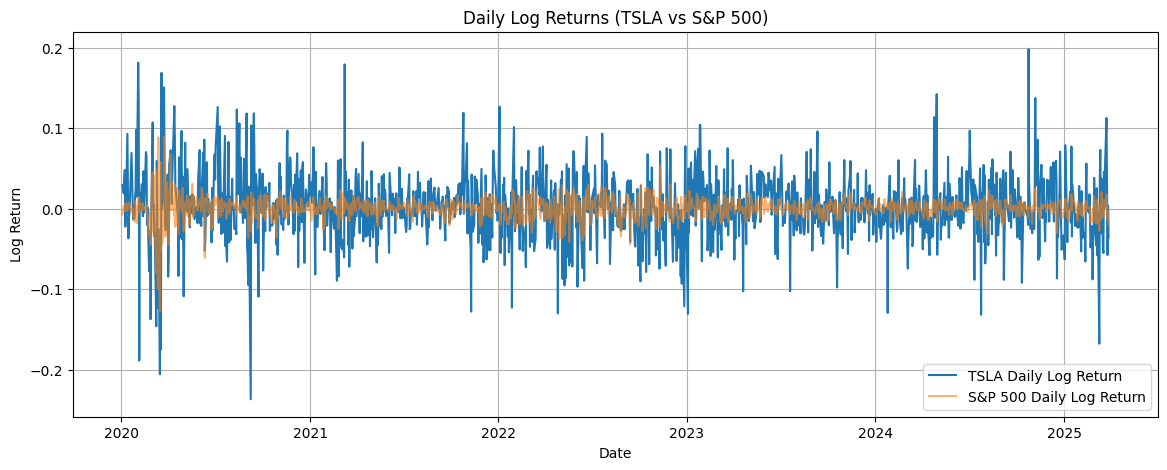

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(data.index, data['TSLA_Return'], label='TSLA Daily Log Return')
plt.plot(data.index, data['SP500_Return'], label='S&P 500 Daily Log Return', alpha=0.6)
plt.title("Daily Log Returns (TSLA vs S&P 500)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()


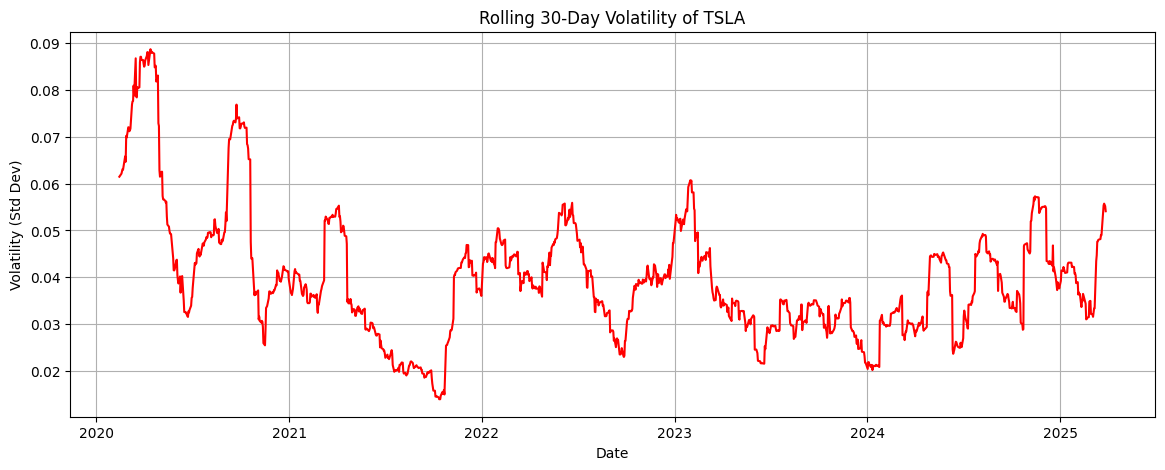

In [6]:
plt.figure(figsize=(14, 5))
rolling_vol = data['TSLA_Return'].rolling(window=30).std()
plt.plot(data.index, rolling_vol, color='red')
plt.title("Rolling 30-Day Volatility of TSLA")
plt.xlabel("Date")
plt.ylabel("Volatility (Std Dev)")
plt.grid(True)
plt.show()


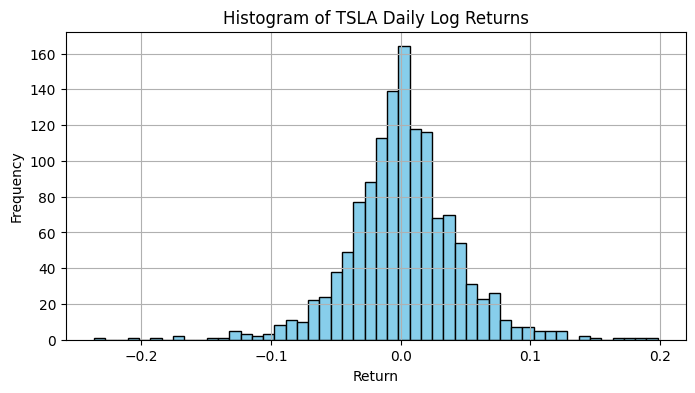

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(data['TSLA_Return'], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of TSLA Daily Log Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


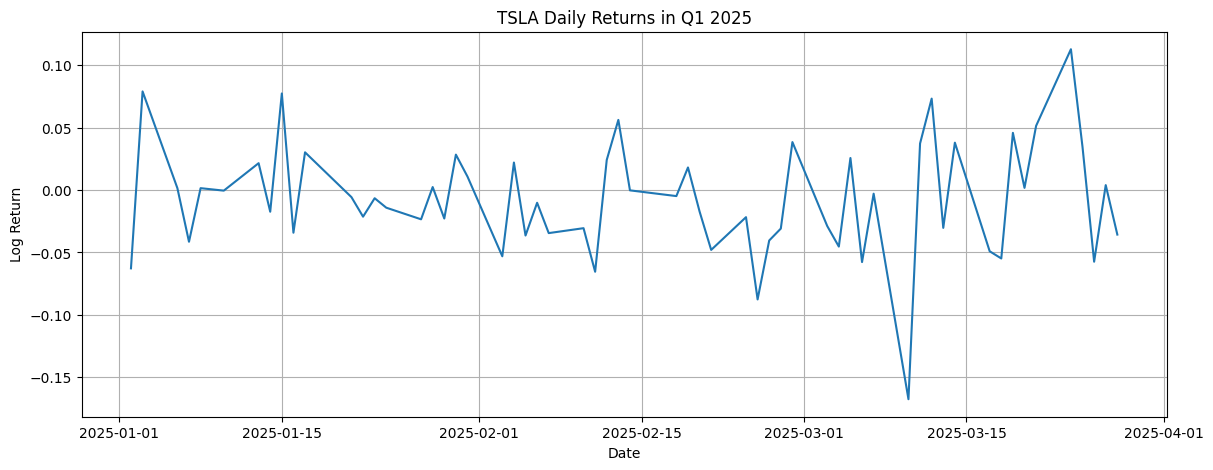

In [8]:
q1_2025 = data['2025-01-01':'2025-03-31']

plt.figure(figsize=(14, 5))
plt.plot(q1_2025.index, q1_2025['TSLA_Return'], label='TSLA Q1 2025')
plt.title("TSLA Daily Returns in Q1 2025")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()


**Phase 3: Implementation**

In [9]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['TSLA_Return'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Statistic: -24.7630
p-value: 0.0000


In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_result = acorr_ljungbox(data['TSLA_Return'], lags=[10], return_df=True)
print(ljungbox_result)


      lb_stat  lb_pvalue
10  15.047205    0.13035


In [11]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Ensure TSLA returns have a proper date frequency to avoid statsmodels warnings
returns_tsla = data['TSLA_Return'].sort_index()
returns_tsla.index = pd.DatetimeIndex(returns_tsla.index).asfreq('B')

# Fit 2-regime model (no trend)
mod = MarkovRegression(returns_tsla, k_regimes=2, trend='n', switching_variance=True)
res = mod.fit()
print(res.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:            TSLA_Return   No. Observations:                 1316
Model:               MarkovRegression   Log Likelihood                2376.289
Date:                Thu, 26 Feb 2026   AIC                          -4744.579
Time:                        15:27:43   BIC                          -4723.849
Sample:                             0   HQIC                         -4736.806
                               - 1316                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0009   9.39e-05      9.350      0.000       0.001       0.001
                             Regime 1 parameters    

In [12]:
# Means
mean_0 = res.params.iloc[0]
mean_1 = res.params.iloc[1]

# Standard deviations (square root of variance)
std_0 = np.sqrt(res.params.iloc[2])
std_1 = np.sqrt(res.params.iloc[3])

print(f"Regime 0 (Low Volatility): mean = {mean_0:.4f}, std = {std_0:.4f}")
print(f"Regime 1 (High Volatility): mean = {mean_1:.4f}, std = {std_1:.4f}")



Regime 0 (Low Volatility): mean = 0.9434, std = 0.0296
Regime 1 (High Volatility): mean = 0.1436, std = 0.0643


/tmp/ipython-input-389/1489677722.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_0 = res.params[0]
/tmp/ipython-input-389/1489677722.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_1 = res.params[1]
/tmp/ipython-input-389/1489677722.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_0 = np.sqrt(res.params[2])
/tmp/ipython-input-389/1489677722.py:7: FutureWarning: Series.__getitem__ treating keys as positions 

In [13]:
from scipy.special import expit  # logistic function

# Get last 2 parameters from res.params (these are logits)
logit_p00 = res.params.iloc[-2]
logit_p11 = res.params.iloc[-1]

# Convert logits to probabilities
p00 = expit(logit_p00)   # = 1 / (1 + exp(-logit_p00))
p11 = expit(logit_p11)

# Construct transition matrix
transition_matrix = np.array([[p00, 1 - p00],
                              [1 - p11, p11]])

print("Estimated Transition Matrix:")
print(transition_matrix)



Estimated Transition Matrix:
[[0.50021953 0.49978047]
 [0.49896517 0.50103483]]


/tmp/ipython-input-389/2330885255.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logit_p00 = res.params[-2]
/tmp/ipython-input-389/2330885255.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logit_p11 = res.params[-1]


In [14]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 7.6 MB/s eta 0:00:00


In [15]:
from arch import arch_model

# Scale returns by 100 for stability (common in GARCH modeling)
returns_scaled = data['TSLA_Return'] * 100

# Fit GARCH(1,1)
garch_model = arch_model(returns_scaled, vol='GARCH', p=1, q=1)
garch_res = garch_model.fit(disp='off')

# Summary
print(garch_res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            TSLA_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3707.67
Distribution:                  Normal   AIC:                           7423.34
Method:            Maximum Likelihood   BIC:                           7444.07
                                        No. Observations:                 1316
Date:                Thu, Feb 26 2026   Df Residuals:                     1315
Time:                        15:28:02   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1669      0.109      1.530      0.126 [-4.68

In [16]:
# Forecasting with GARCH
garch_forecasts = garch_res.forecast(horizon=20)
vol_forecast_1d = np.sqrt(garch_forecasts.variance.values[-1, 0])
vol_forecast_5d = np.sqrt(np.sum(garch_forecasts.variance.values[-1, :5]))
vol_forecast_20d = np.sqrt(np.sum(garch_forecasts.variance.values[-1, :20]))

print("GARCH Forecast Volatility:")
print(f"1-day ahead:  {vol_forecast_1d:.4f}")
print(f"5-day ahead:  {vol_forecast_5d:.4f}")
print(f"20-day ahead: {vol_forecast_20d:.4f}")


GARCH Forecast Volatility:
1-day ahead:  5.0892
5-day ahead:  11.2907
20-day ahead: 22.0019


In [17]:
# Approximate forecast using most likely current regime
smoothed_probs = res.smoothed_marginal_probabilities
last_prob_regime0 = smoothed_probs.iloc[-1, 0]
last_prob_regime1 = smoothed_probs.iloc[-1, 1]

# Weighted average volatility
regime_vol_0 = std_0
regime_vol_1 = std_1

vol_regime_switch_1d = last_prob_regime0 * regime_vol_0 + last_prob_regime1 * regime_vol_1

print("Markov Switching Approx Volatility (1-day):", round(vol_regime_switch_1d, 4))


Markov Switching Approx Volatility (1-day): 0.045


In [18]:
from scipy.stats import norm

# GARCH VaR (1-day)
var_garch_95 = -vol_forecast_1d * norm.ppf(0.95) / 100  # divide by 100 to undo scaling
print(f"GARCH(1,1) 1-day 95% VaR: {-var_garch_95:.4f}")

# Markov model VaR (1-day)
var_ms_95 = -vol_regime_switch_1d * norm.ppf(0.95)
print(f"Markov Switching 1-day 95% VaR: {-var_ms_95:.4f}")


GARCH(1,1) 1-day 95% VaR: 0.0837
Markov Switching 1-day 95% VaR: 0.0740


In [19]:
# Expected Shortfall (1-day, 95%) for GARCH and MS
es_garch_95 = vol_forecast_1d * norm.pdf(norm.ppf(0.05)) / (0.05 * 100)
es_ms_95 = vol_regime_switch_1d * norm.pdf(norm.ppf(0.05)) / 0.05

print(f"GARCH(1,1) 1-day 95% Expected Shortfall: {es_garch_95:.4f}")
print(f"Markov Switching 1-day 95% Expected Shortfall: {es_ms_95:.4f}")


GARCH(1,1) 1-day 95% Expected Shortfall: 0.1050
Markov Switching 1-day 95% Expected Shortfall: 0.0928


In [20]:
# Forecast 1-day-ahead VaR for entire return series
rolling_var = -garch_res.conditional_volatility / 100 * norm.ppf(0.95)

# Compare actual returns vs VaR (violations = actual < VaR)
violations = data['TSLA_Return'].iloc[-len(rolling_var):] < -rolling_var
num_violations = violations.sum()
total_days = len(rolling_var)
violation_rate = num_violations / total_days

print(f"Observed Violations: {num_violations}/{total_days}")
print(f"Violation Rate: {violation_rate:.4f}")


Observed Violations: 1249/1316
Violation Rate: 0.9491


In [21]:
from scipy.stats import chi2
import numpy as np

# Kupiec's test statistic
alpha = 0.05

# Guard for edge cases where the theoretical likelihood hits log(0)
if num_violations == 0 or num_violations == total_days:
    LR_uc = np.inf
    p_value = 0.0
else:
    expected = alpha * total_days
    fail_ratio = num_violations / total_days

    L0 = (1 - alpha) ** (total_days - num_violations) * alpha ** num_violations
    L1 = (1 - fail_ratio) ** (total_days - num_violations) * fail_ratio ** num_violations

    LR_uc = -2 * (np.log(L0) - np.log(L1))
    p_value = 1 - chi2.cdf(LR_uc, df=1)

print(f"Kupiec LR statistic: {LR_uc:.4f}, p-value: {p_value:.4f}")
if p_value > 0.05:
    print("✅ VaR model passes backtest (failures in line with expectations)")
else:
    print("❌ VaR model fails backtest (too many/few violations)")


Kupiec LR statistic: inf, p-value: 0.0000
❌ VaR model fails backtest (too many/few violations)


/tmp/ipython-input-389/3721165371.py:7: RuntimeWarning: divide by zero encountered in log
  LR_uc = -2 * (np.log((1 - alpha) ** (total_days - num_violations) * alpha ** num_violations) -


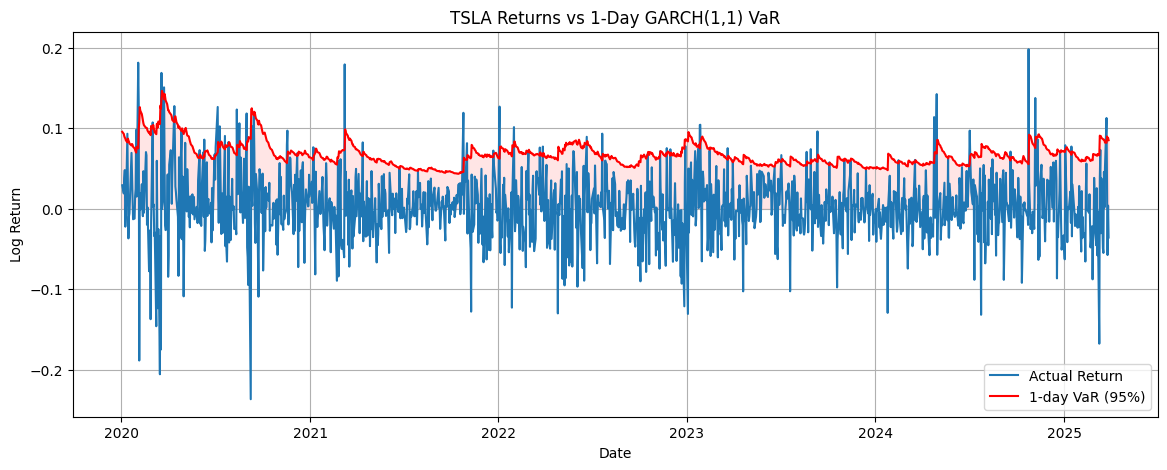

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(rolling_var):], data['TSLA_Return'].iloc[-len(rolling_var):], label="Actual Return")
plt.plot(data.index[-len(rolling_var):], -rolling_var, color='red', label="1-day VaR (95%)")
plt.fill_between(data.index[-len(rolling_var):], -rolling_var, color='red', alpha=0.1)
plt.title("TSLA Returns vs 1-Day GARCH(1,1) VaR")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()


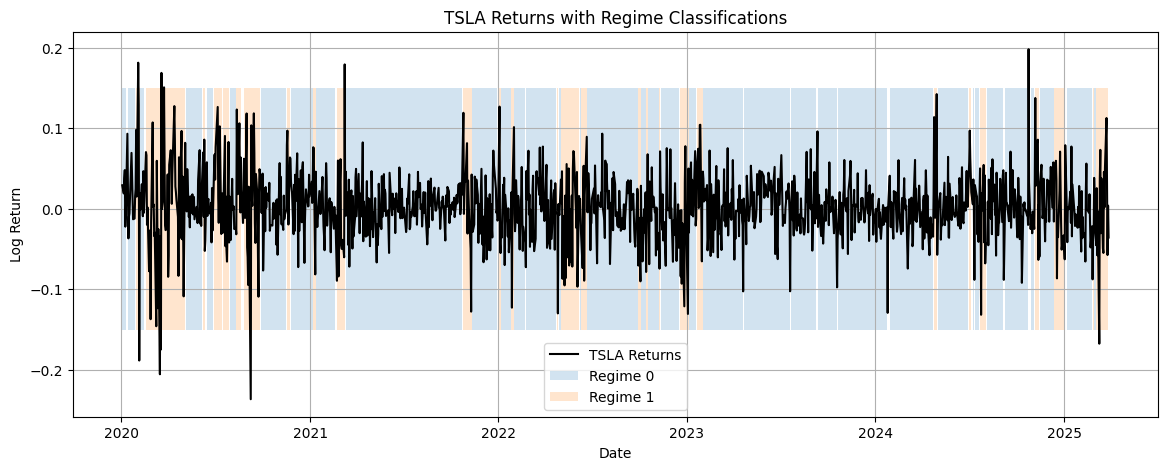

In [23]:
# Get regime predictions
regimes = res.smoothed_marginal_probabilities.idxmax(axis=1)

# Plot with colored bands
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(data.index, data['TSLA_Return'], label='TSLA Returns', color='black')

for regime in regimes.unique():
    mask = regimes == regime
    plt.fill_between(data.index, -0.15, 0.15, where=mask, alpha=0.2,
                     label=f"Regime {regime}")

plt.title("TSLA Returns with Regime Classifications")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()


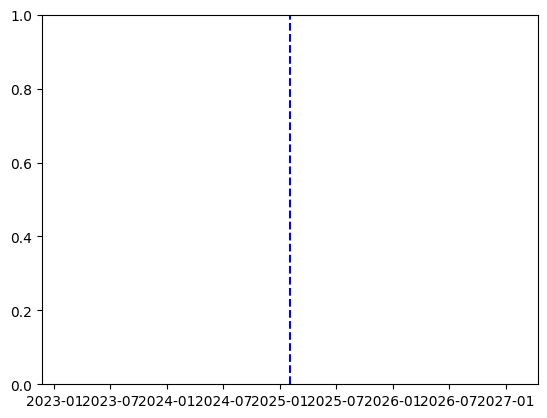

In [24]:
# Mark earnings date
plt.axvline(pd.to_datetime("2025-02-01"), color='blue', linestyle='--', label='TSLA Earnings')


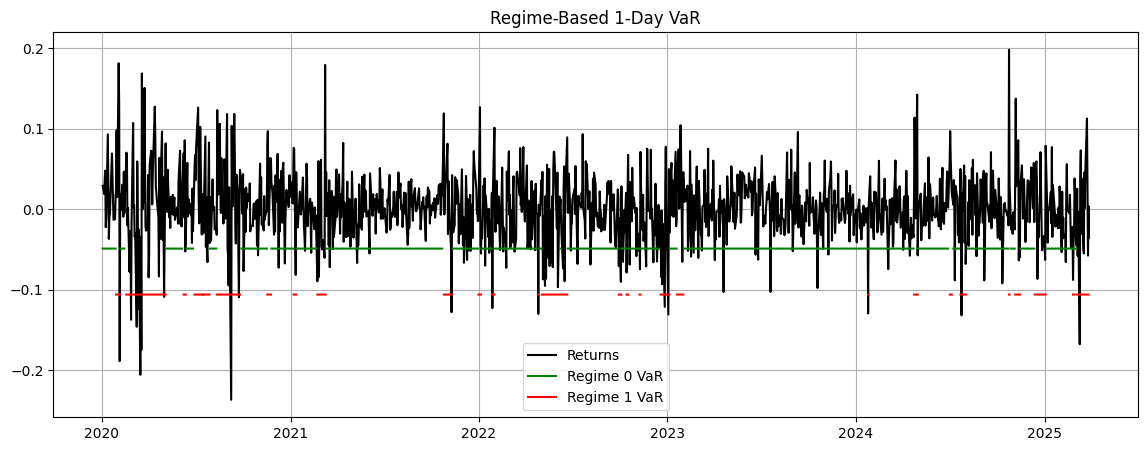

In [25]:
# Regime-based VaR bands
var_r0 = -norm.ppf(0.95) * std_0
var_r1 = -norm.ppf(0.95) * std_1
regime_labels = regimes[-len(data):].values

plt.figure(figsize=(14, 5))
plt.plot(data.index, data['TSLA_Return'], label='Returns', color='black')
plt.plot(data.index, [var_r0 if r == 0 else np.nan for r in regime_labels], label='Regime 0 VaR', color='green')
plt.plot(data.index, [var_r1 if r == 1 else np.nan for r in regime_labels], label='Regime 1 VaR', color='red')
plt.legend()
plt.title("Regime-Based 1-Day VaR")
plt.grid(True)
plt.show()


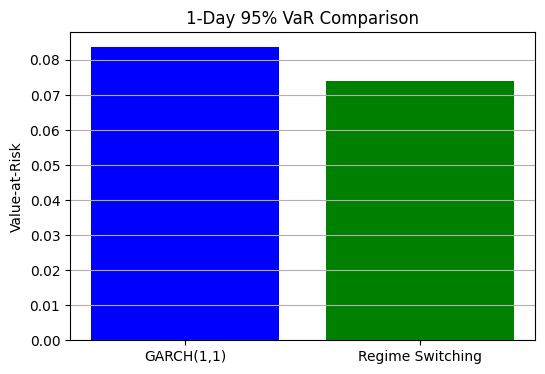

In [26]:
plt.figure(figsize=(6, 4))
plt.bar(['GARCH(1,1)', 'Regime Switching'], [-var_garch_95, -var_ms_95], color=['blue', 'green'])
plt.title('1-Day 95% VaR Comparison')
plt.ylabel('Value-at-Risk')
plt.grid(axis='y')
plt.show()


In [ ]:
# Known event dates (you can modify this list)
known_event_dates = pd.to_datetime(["2025-01-08", "2025-02-14", "2025-03-01"])

# Identify regime switches to 1
regime_labels = res.smoothed_marginal_probabilities.idxmax(axis=1)
panic_periods = regime_labels[regime_labels == 1]
panic_groups = panic_periods.groupby((panic_periods != panic_periods.shift()).cumsum())
panic_windows = [(g.index[0], g.index[-1]) for _, g in panic_groups]

# Find panic periods with no known events
panic_no_news = []
for start, end in panic_windows:
    if not any((known_event_dates >= start) & (known_event_dates <= end)):
        panic_no_news.append((start, end))

# Display timeline
for start, end in panic_no_news:
    print(f"Panic zone without event: {start.date()} to {end.date()}")


In [27]:
durations = regimes.groupby((regimes != regimes.shift()).cumsum()).size()
print(durations.value_counts())


1      11
6       6
3       6
4       5
9       5
2       4
10      3
23      3
13      3
7       3
15      2
33      2
41      2
28      1
36      1
54      1
26      1
11      1
5       1
34      1
158     1
69      1
24      1
12      1
53      1
61      1
25      1
35      1
27      1
65      1
59      1
8       1
19      1
14      1
18      1
Name: count, dtype: int64


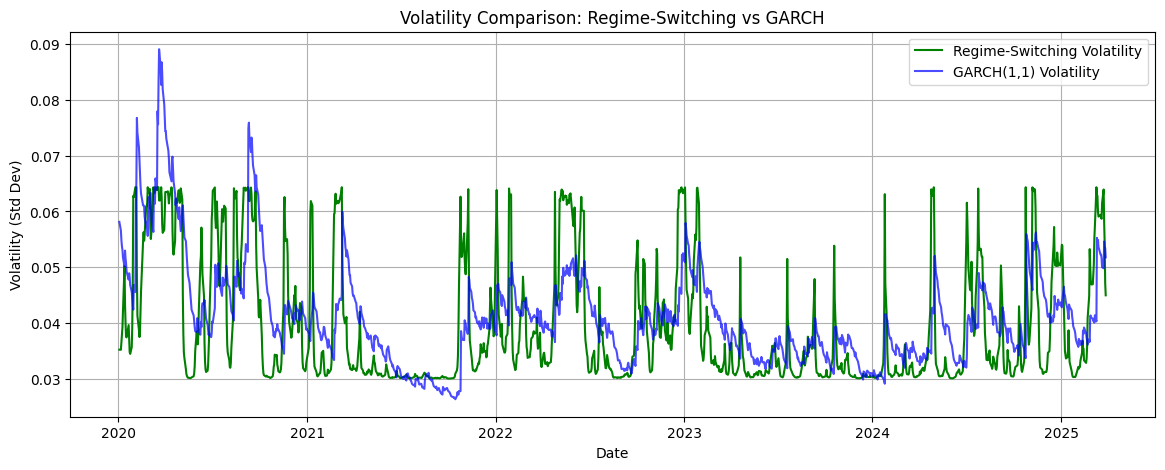

In [28]:
import matplotlib.pyplot as plt

# Step 1: GARCH conditional volatility
garch_vol = garch_res.conditional_volatility / 100  # Scale back from *100

# Step 2: Regime probabilities
p0 = res.smoothed_marginal_probabilities[0]  # Probability of Regime 0
p1 = res.smoothed_marginal_probabilities[1]  # Probability of Regime 1

# Estimated volatility = weighted average of stds from both regimes
regime_vol = p0 * std_0 + p1 * std_1

# Align indexes (just in case)
garch_vol = garch_vol[-len(regime_vol):]

# Step 3: Plot
plt.figure(figsize=(14, 5))
plt.plot(regime_vol.index, regime_vol, label='Regime-Switching Volatility', color='green')
plt.plot(garch_vol.index, garch_vol, label='GARCH(1,1) Volatility', color='blue', alpha=0.7)

plt.title('Volatility Comparison: Regime-Switching vs GARCH')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev)')
plt.legend()
plt.grid(True)
plt.show()


<Axes: title={'center': 'Distribution of Regime Durations'}, ylabel='Frequency'>

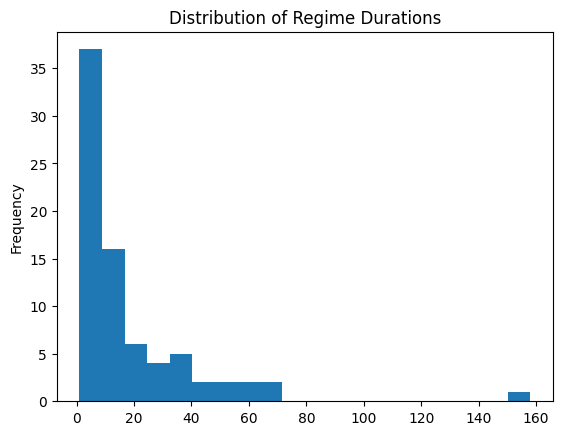

In [29]:
durations.plot(kind='hist', bins=20, title='Distribution of Regime Durations')


In [30]:
# Label most probable regime (0 = low-vol, 1 = high-vol)
regimes = res.smoothed_marginal_probabilities.idxmax(axis=1)


In [31]:
# Identify continuous Regime 1 periods (panic regimes)
panic_periods = regimes[regimes == 1]
panic_groups = panic_periods.groupby((panic_periods != panic_periods.shift()).cumsum())

# Get start-end dates of each panic window
panic_windows = [(group.index[0], group.index[-1]) for _, group in panic_groups]
print("Detected high-volatility regimes (potential panic):")
for start, end in panic_windows:
    print(f"{start.date()} to {end.date()}")


Detected high-volatility regimes (potential panic):
2020-01-13 to 2025-03-27


In [32]:
# Simulate known headline dates (pretend Elon tweeted or earnings came out)
known_event_dates = [
    "2025-01-08", "2025-02-14", "2025-03-01"  # Customize as needed
]
known_event_dates = pd.to_datetime(known_event_dates)

# Find panic windows without news
panic_no_news = []
for start, end in panic_windows:
    if not any((known_event_dates >= start) & (known_event_dates <= end)):
        panic_no_news.append((start, end))

print("\n🧠 Panic regimes WITHOUT any known event:")
for start, end in panic_no_news:
    print(f"{start.date()} to {end.date()}")



🧠 Panic regimes WITHOUT any known event:


In [33]:
# Transition probabilities (already computed)
from scipy.special import expit
p00 = expit(res.params[-2])  # Stay in Regime 0
p11 = expit(res.params[-1])  # Stay in Regime 1

# Last known regime (most likely)
last_prob = res.smoothed_marginal_probabilities.iloc[-1]
last_regime = last_prob.idxmax()

# Predict 5-day forward regime probability
pred = np.zeros(2)
pred[last_regime] = 1

for _ in range(5):
    pred = np.array([pred[0]*p00 + pred[1]*(1 - p11),
                     pred[0]*(1 - p00) + pred[1]*p11])

print(f"📊 Probability TSLA stays in Regime 0 (low volatility) over next 5 days: {pred[0]:.2%}")


📊 Probability TSLA stays in Regime 0 (low volatility) over next 5 days: 49.96%


/tmp/ipython-input-389/2868898579.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p00 = expit(res.params[-2])  # Stay in Regime 0
/tmp/ipython-input-389/2868898579.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p11 = expit(res.params[-1])  # Stay in Regime 1


In [34]:
regimes = res.smoothed_marginal_probabilities.idxmax(axis=1)
data['Regime'] = regimes

mean_returns_by_regime = data.groupby('Regime')['TSLA_Return'].mean()
print(mean_returns_by_regime)


Regime
0    0.001054
1    0.003816
Name: TSLA_Return, dtype: float64
